In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt

import pandas as pd


In [3]:
# adapted from ChatGPT

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, output_size)
        )
        # self.activation = nn.LeakyReLU()

    def forward(self, x):
        x = self.stack(x)
        # x = self.activation(x)
        return x

In [4]:
class DQLAgent:
    def __init__(self, input_size, output_size, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999,
                 target_update_frequency=10, memory_capacity=10000, batch_size=64):
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_frequency = target_update_frequency
        self.memory = []
        self.memory_capacity = memory_capacity
        self.batch_size = batch_size
        self.dqn = DQN(input_size, output_size)
        self.target_dqn = DQN(input_size, output_size)
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.target_dqn.eval()
        self.optimizer = torch.optim.Adam(self.dqn.parameters())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice([0, 1, 2, 3])
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self.dqn(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_capacity:
            self.memory.pop(0)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        q_values = self.dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_dqn(next_states).max(1).values
        target_values = rewards + (1 - dones) * self.gamma * next_q_values
        loss = F.smooth_l1_loss(q_values, target_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def target_update(self, episode):
        if episode % self.target_update_frequency == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())



In [51]:
def matrix_to_tuple(matrix):
    return torch.tensor((matrix[0][1], matrix[0][2], matrix[1][2]),dtype=torch.long)

# B is the inverse of A
A = torch.tensor([[1, 1, 0], [0, 1, 0], [0, 0, 1]])
B = torch.tensor([[1, -1, 0], [0, 1, 0], [0, 0, 1]])

# C is the inverse of D
C = torch.tensor([[1, 0, 0], [0, 1, 1], [0, 0, 1]])
D = torch.tensor([[1, 0, 0], [0, 1, -1], [0, 0, 1]])
actions = [A,B,C,D]

identity = torch.eye(3)

# together, A, B, C, and D generate the heisenberg group

In [6]:
df = pd.read_csv("../Data_Generation/Data_files/heisenberg_data.csv")

In [7]:
step_penalty = -10
def getReward(term_rwd, matrix):
    if (matrix==identity).all():
        return term_rwd
    else:
        return step_penalty

In [50]:
def tuple_to_matrix(tup):
    assert len(tup)==3
    return torch.tensor([
        [1, int(tup[0]), int(tup[1])], 
        [0, 1, int(tup[2])], 
        [0, 0, 1]
        ],dtype=torch.long)

In [9]:
def take_action(state, action):
    return state @ actions[action]

In [10]:
def get_next_step(term_rwd, oldObs, action):
    # action is always either 0, 1, 2, or 3
    next_state = []
    oldObs = tuple_to_matrix(oldObs)

    next_state = take_action(oldObs, action)
    
    curReward = getReward(term_rwd, next_state)
    done = curReward==term_rwd
    return (matrix_to_tuple(next_state), curReward, done)

In [11]:
input_size = 3
output_size = 4

agent2 = DQLAgent(input_size, output_size)


Episode 50, Total Reward: -30030
Episode 100, Total Reward: -1460
Episode 150, Total Reward: -1730
Episode 200, Total Reward: -14980
Episode 250, Total Reward: -6480
Episode 300, Total Reward: -6450
Episode 350, Total Reward: -760
Episode 400, Total Reward: -70
Episode 450, Total Reward: -1350
Episode 500, Total Reward: -70
Episode 550, Total Reward: -8210
Episode 600, Total Reward: -590
Episode 650, Total Reward: -650
Episode 700, Total Reward: -1500
Episode 750, Total Reward: -1180
Episode 800, Total Reward: -1290
Episode 850, Total Reward: -6190
Episode 900, Total Reward: -10420
Episode 950, Total Reward: -590
Episode 1000, Total Reward: -27780
Episode 1050, Total Reward: -19550
Episode 1100, Total Reward: -4640
Episode 1150, Total Reward: -370
Episode 1200, Total Reward: -15560
Episode 1250, Total Reward: -2120
Episode 1300, Total Reward: -10910
Episode 1350, Total Reward: -1820
Episode 1400, Total Reward: -2220
Episode 1450, Total Reward: -6510
Episode 1500, Total Reward: -6980
Ep

In [25]:
# track_rewards = []

for episode in range(4000):
    cur_row = df.sample(1)
    state = (cur_row['val1'].values[0], cur_row['val2'].values[0], cur_row['val3'].values[0])
    term_rwd = torch.linalg.norm(torch.tensor(state,dtype=torch.float32))
    # term_rwd = 10000

    total_reward = 0
    for t in range(int(term_rwd ** 2)):
        action = agent2.select_action(state)
        next_state, reward, done = get_next_step(term_rwd, state, action)
        agent2.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent2.replay()
    agent2.target_update(episode)
    if (episode + 1) % 50 == 0:
        print(f'Episode {episode + 1}, Total Reward: {total_reward}')
    # track_rewards.append(total_reward)

Episode 50, Total Reward: -680
Episode 100, Total Reward: -410
Episode 150, Total Reward: -410
Episode 200, Total Reward: -15230
Episode 250, Total Reward: -7090
Episode 300, Total Reward: -7260
Episode 350, Total Reward: -4750
Episode 400, Total Reward: -2020
Episode 450, Total Reward: -15490
Episode 500, Total Reward: -31160
Episode 550, Total Reward: -5360
Episode 600, Total Reward: -190
Episode 650, Total Reward: -890
Episode 700, Total Reward: -610
Episode 750, Total Reward: -1520
Episode 800, Total Reward: -3420
Episode 850, Total Reward: -660
Episode 900, Total Reward: -510
Episode 950, Total Reward: -8350
Episode 1000, Total Reward: -890
Episode 1050, Total Reward: -360
Episode 1100, Total Reward: -530
Episode 1150, Total Reward: -25530
Episode 1200, Total Reward: -60
Episode 1250, Total Reward: -15500
Episode 1300, Total Reward: -170
Episode 1350, Total Reward: -400
Episode 1400, Total Reward: -140
Episode 1450, Total Reward: -4730
Episode 1500, Total Reward: -1580
Episode 155

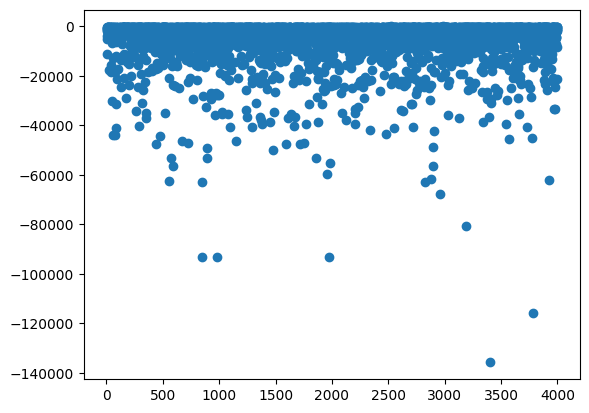

In [26]:
plt.scatter(x=np.arange(1, 1+len(track_rewards)), y=track_rewards)

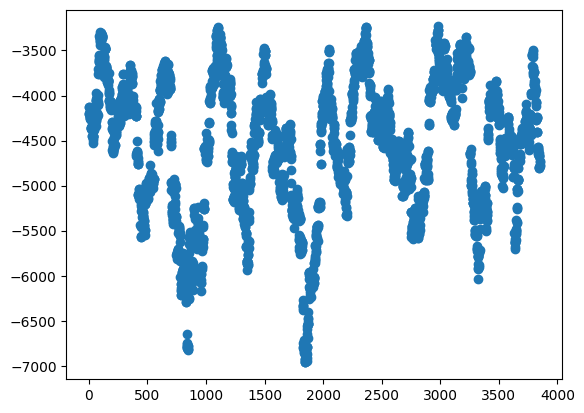

In [27]:
# moving average adapted from ChatGPT
def moving_average(arr, window_size):
    cumsum = np.cumsum(arr)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


window_size = 150
moving_avg = moving_average(track_rewards, window_size)


plt.scatter(x=np.arange(1, 1+len(moving_avg)), y=moving_avg)

# plt.savefig("why_does_performance_worsen.png")
plt.show()

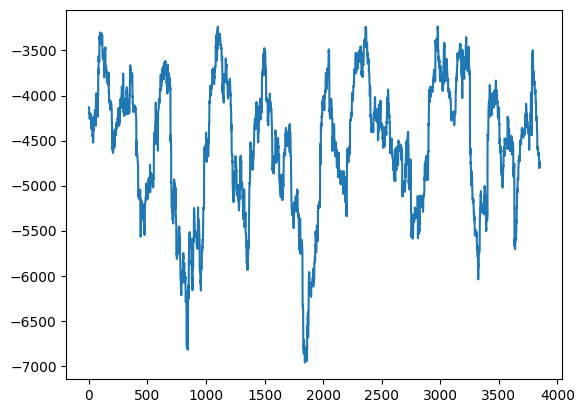

In [14]:
plt.plot(np.arange(1, 1+len(moving_avg)), moving_avg)

In [28]:
s = (100, 0, 0)
s2 = torch.tensor(s, dtype=torch.float32) 
q_values = agent2.dqn(s2)
q_values

tensor([-659.8529, -648.3065, -659.5960, -647.0410], grad_fn=<AddBackward0>)

In [58]:
def execute_sequence(state, policy_fn, k_max_steps=100):
    states = []
    states.append(state)
    for i in range(k_max_steps):
        if state.flatten().equal(torch.zeros((1,3))):
            break
        print(state)
        state = take_action(tuple_to_matrix(state), policy_fn(state.float()))
        states.append(matrix_to_tuple(state))
        state = matrix_to_tuple(state)
    return states

def max_policy(state):
    return torch.argmax(agent2.dqn(state))
    

In [59]:
example = torch.zeros(3,dtype=torch.long)
example[0] = 100
seq = execute_sequence(example, max_policy)
print(len(seq))

tensor([100,   0,   0])
tensor([ 100, -100,   -1])
tensor([  99, -100,   -1])
tensor([  98, -100,   -1])
tensor([  97, -100,   -1])
tensor([  96, -100,   -1])
tensor([  95, -100,   -1])
tensor([  94, -100,   -1])
tensor([  93, -100,   -1])
tensor([  92, -100,   -1])
tensor([  91, -100,   -1])
tensor([  90, -100,   -1])
tensor([  89, -100,   -1])
tensor([  88, -100,   -1])
tensor([  87, -100,   -1])
tensor([  86, -100,   -1])
tensor([  85, -100,   -1])
tensor([  84, -100,   -1])
tensor([  83, -100,   -1])
tensor([  82, -100,   -1])
tensor([  81, -100,   -1])
tensor([  80, -100,   -1])
tensor([  79, -100,   -1])
tensor([  78, -100,   -1])
tensor([  77, -100,   -1])
tensor([  76, -100,   -1])
tensor([  75, -100,   -1])
tensor([  74, -100,   -1])
tensor([  73, -100,   -1])
tensor([  72, -100,   -1])
tensor([  71, -100,   -1])
tensor([  70, -100,   -1])
tensor([  69, -100,   -1])
tensor([  68, -100,   -1])
tensor([  67, -100,   -1])
tensor([  66, -100,   -1])
tensor([  65, -100,   -1])
tens